In [45]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
import os 
import geopandas as gpd
import os 
import sys
from argparse import Namespace
import pickle
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
from pipeline.plotting.plotting import plot_heatmap,plot_coverage_matshow
from examples.load_best_config import load_trainer_ds_from_saved_trial
from examples.train_and_visu_non_recurrent import get_df_for_visualisation,visualisation_special_event
import pandas as pd

working_dir = os.path.expanduser('~/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/optim')

## Load trained model and trainer from save: 

In [46]:
subfolder = 'best_models'
target_data = 'subway_in'
model_name = 'STAEformer'
trial_id = 'subway_in_calendar_h1_bis1'  
model_id = f"{trial_id}_f5"     # One trial_id can be associated to several folds 


model_args = pickle.load(open(f"{working_dir}/{target_data}_{model_name}/{subfolder}/model_args.pkl",'rb'))
model_save_path = f"{working_dir}/{target_data}_{model_name}/{subfolder}/{model_id}.pkl"

args = model_args['model'][model_id]['args']
args = Namespace(**args)

trainer, ds, args_init = load_trainer_ds_from_saved_trial(args,model_save_path,
                                                          modification = {'shuffle':False,
                                                                                               'data_augmentation':False })


----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 00:00:00 and 2019-12-31 23:45:00
Invalid dates within this fold: 1233

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([35040, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([14967, 40, 7])
   VALID contextual_ds: torch.Size([4989, 40, 7])
   TEST contextual_ds: torch.Size([4989, 40, 7])

>>>Loading calendar inputs ...
Init U/Utarget size: torch.Size([24946, 40, 7])/torch.Size([24946, 40, 1]) Train/Valid/Test 14967 4989 4989

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

----------------------------------------
Loading the dataset for fold n°5
Model size: 0.002GB


In [ ]:
from examples.train_and_visu_non_recurrent import get_df_for_visualisation,visualisation_special_event
training_mode = 'test'
station=['BEL']
Preds,Y_true,T_labels = trainer.testing(ds.normalizer, training_mode =training_mode)   
df_true,df_predictions = get_df_for_visualisation(ds,Preds,Y_true,training_mode,trainer.out_dim_factor,stations=station)
visualisation_special_event(trainer,df_true,df_predictions,station=station,min_flow=0)

print('MAE: ',torch.abs(Y_true-Preds).mean().item(),'\n',
      'RMSE: ', np.sqrt(((Y_true-Preds)**2).mean().item()),'\n',
      'MSE: ', ((Y_true-Preds)**2).mean().item(),'\n'
)

Loading BokehJS ...

MAE:  20.392898559570312 
 RMSE:  35.641238075612634 
 MSE:  1270.2978515625 



Process ForkProcess-17:
Process ForkProcess-24:
Process ForkProcess-27:
Process ForkProcess-16:
Process ForkProcess-25:
Process ForkProcess-32:
Process ForkProcess-33:
Process ForkProcess-9:
Process ForkProcess-21:
Process ForkProcess-12:
Process ForkProcess-5:
Process ForkProcess-6:
Process ForkProcess-13:
Process ForkProcess-8:
Process ForkProcess-22:
Process ForkProcess-26:
Process ForkProcess-11:
Process ForkProcess-23:
Process ForkProcess-29:
Process ForkProcess-30:
Process ForkProcess-15:
Process ForkProcess-20:
Process ForkProcess-7:
Process ForkProcess-10:
Process ForkProcess-14:
Process ForkProcess-31:
Process ForkProcess-36:
Process ForkProcess-35:
Process ForkProcess-18:
Process ForkProcess-28:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-34:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-19:
Traceback (most recent call

## Analyse attn weights
- La dimension des input en entrée d'Attention Layer est `[num_heads * batch_size, ..., head_dim, src_length]`. 
- L'attention est ensuite portée sur la dimension spatiale ou la dimension temporelles (ici 'src_length')


In [47]:
X = torch.cat([x for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
Y = torch.cat([y for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
Xc0 = torch.cat([x_c[0] for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
Xc1 = torch.cat([x_c[1] for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
model = trainer.model
model.eval()
with torch.no_grad():
    pred = model(X,[Xc0,Xc1])

## Attention Score on Temporal Attn Layer: 

<Figure size 2000x1000 with 0 Axes>

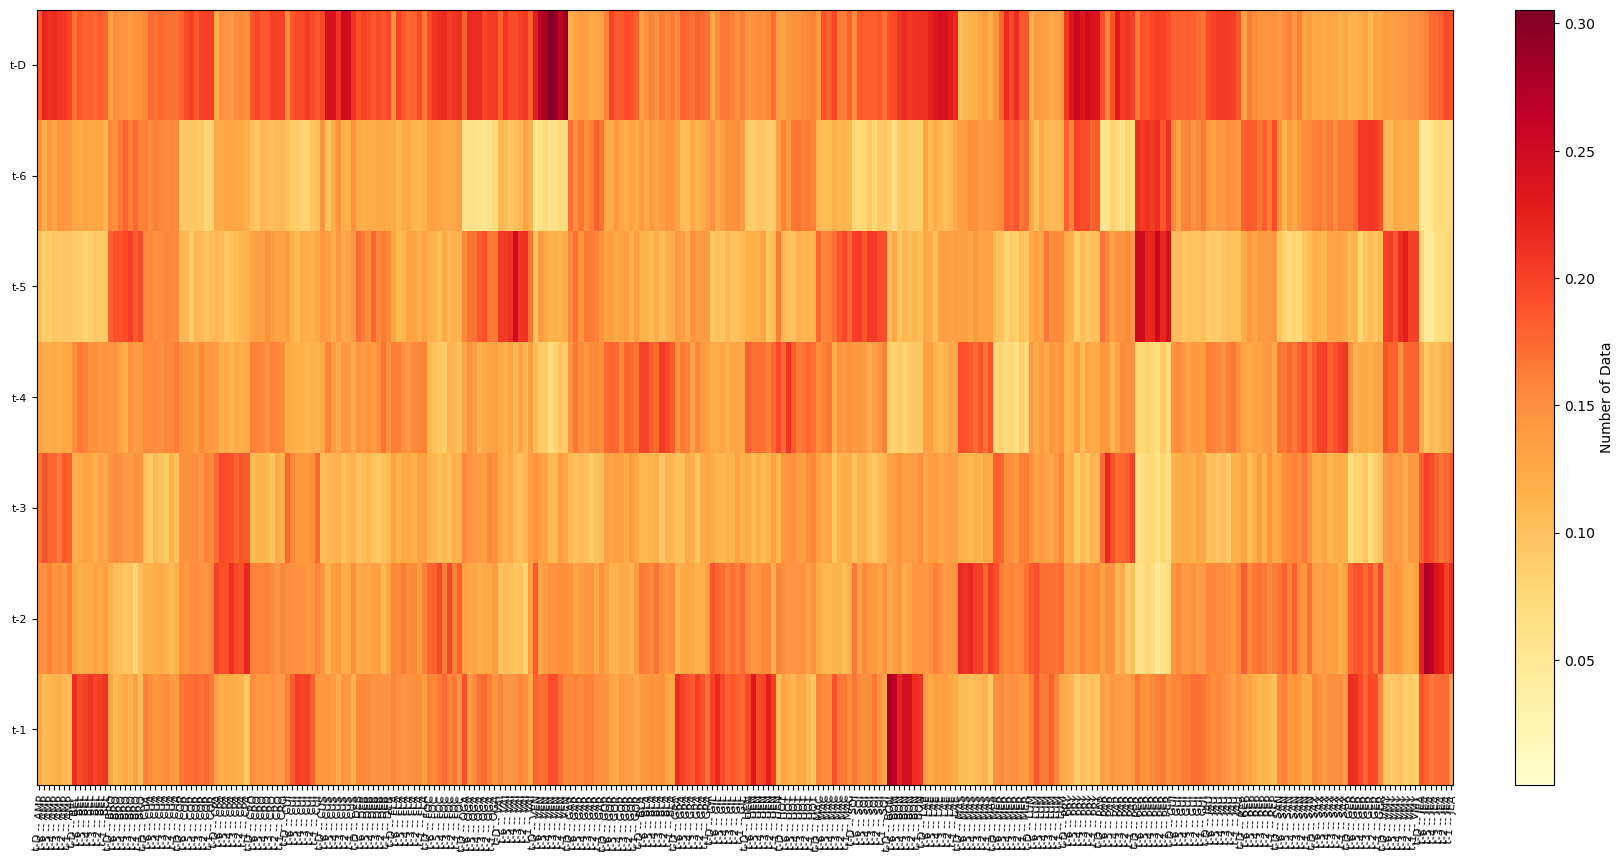

<Figure size 2000x1000 with 0 Axes>

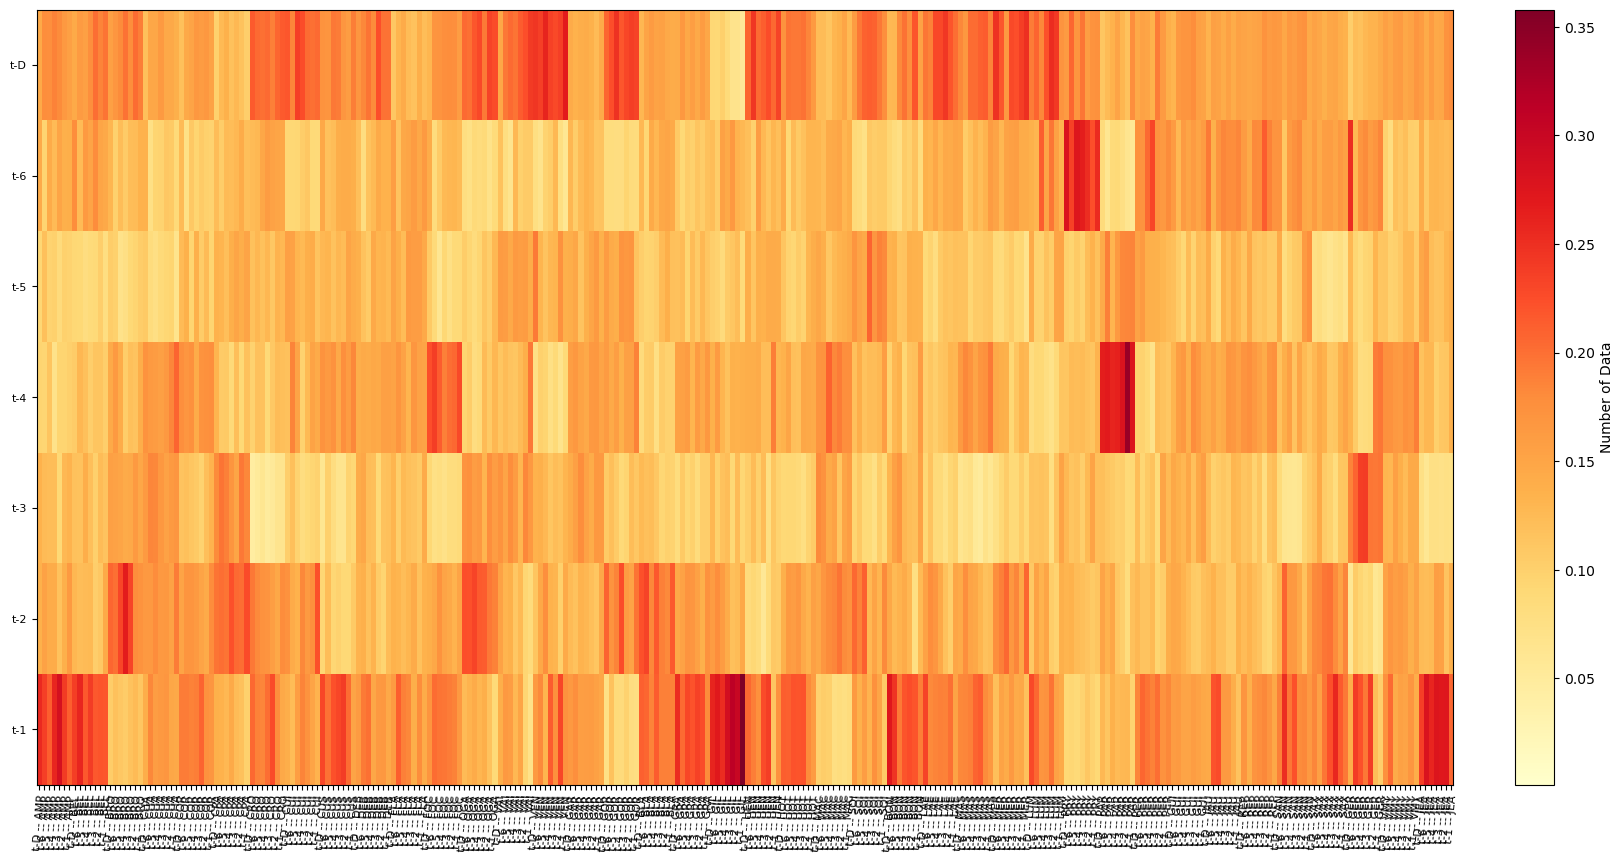

<Figure size 2000x1000 with 0 Axes>

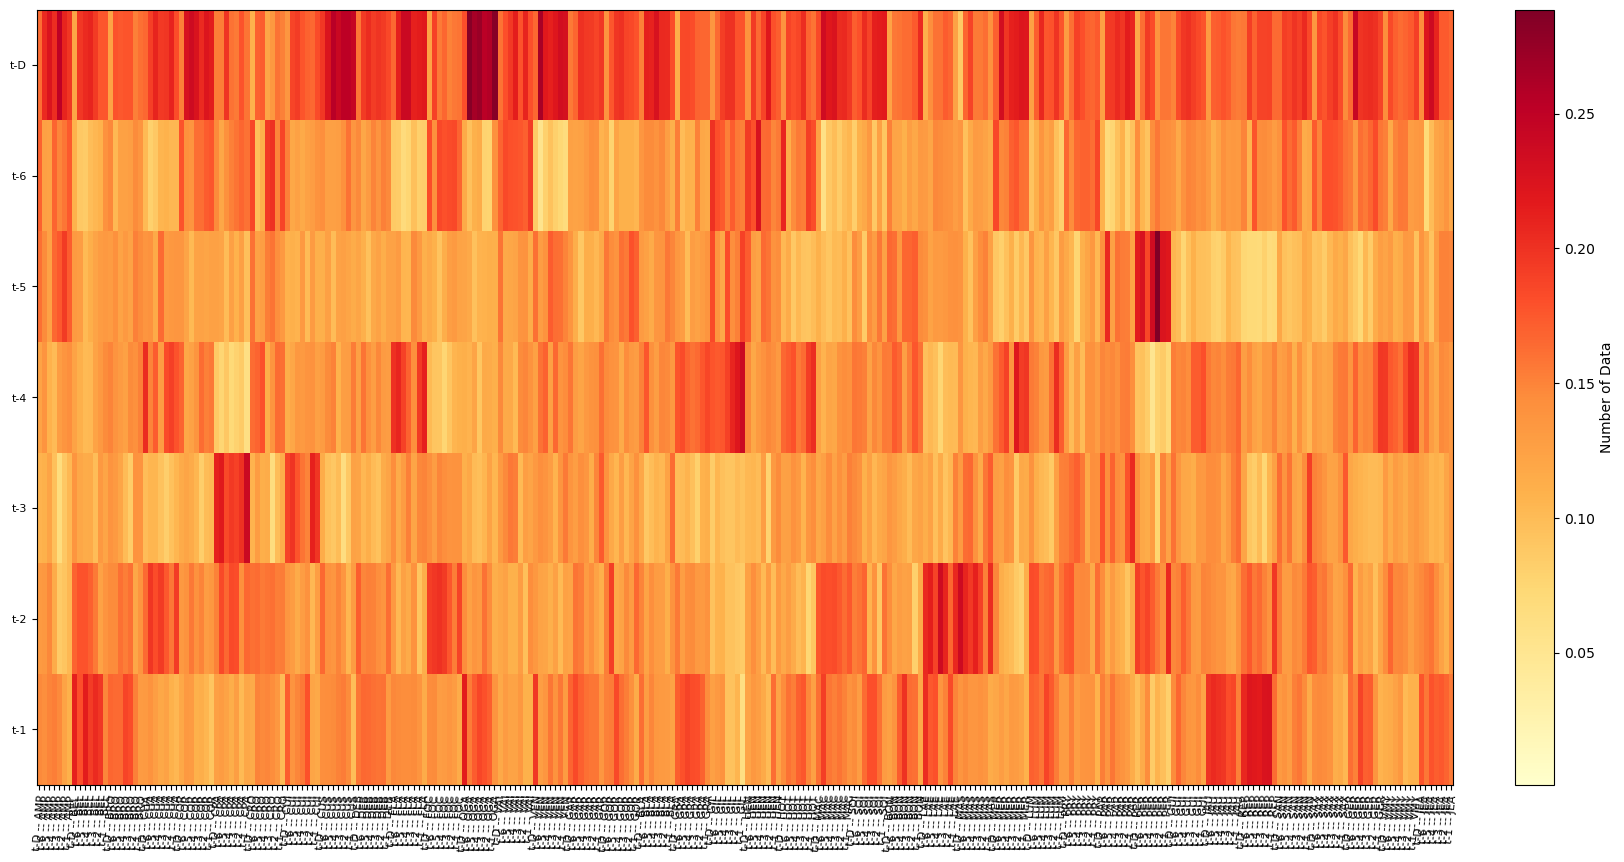

In [ ]:
columns = ['t-D','t-6','t-5','t-4','t-3','t-2','t-1']

for temporal_layer in range(len(trainer.model._orig_mod.core_model.attn_layers_t)):
  attn_score = trainer.model._orig_mod.core_model.attn_layers_t[temporal_layer].attn.attn_score.detach().cpu()     # attn_score.size : torch.Size([19956, 40, 7, 7]) - - [B,N,L,L] 
  mean_attn_score = attn_score.mean(0)                                                                             #  mean_attn_score.size(): [40, 7, 7]             - -   [N,L,L]
  df_attn_weight = pd.DataFrame(mean_attn_score.reshape(-1,mean_attn_score.shape[-1]).numpy(),columns=columns,index=[f"{hist} -- {station_name}"   for station_name in ds.spatial_unit for hist in columns] )
  figsize=(20,10)
  matfig = plt.figure(figsize=figsize)
  plot_coverage_matshow(df_attn_weight.T, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False,
                          #   ,v_min=None,v_max=None,
                          #   display_values = False,
                            bool_plot = True,
                            cbar_magic_args = True,
                            figsize = figsize
  )

## Attn-Score on Spatial-Attn Layer

<Figure size 2000x1000 with 0 Axes>

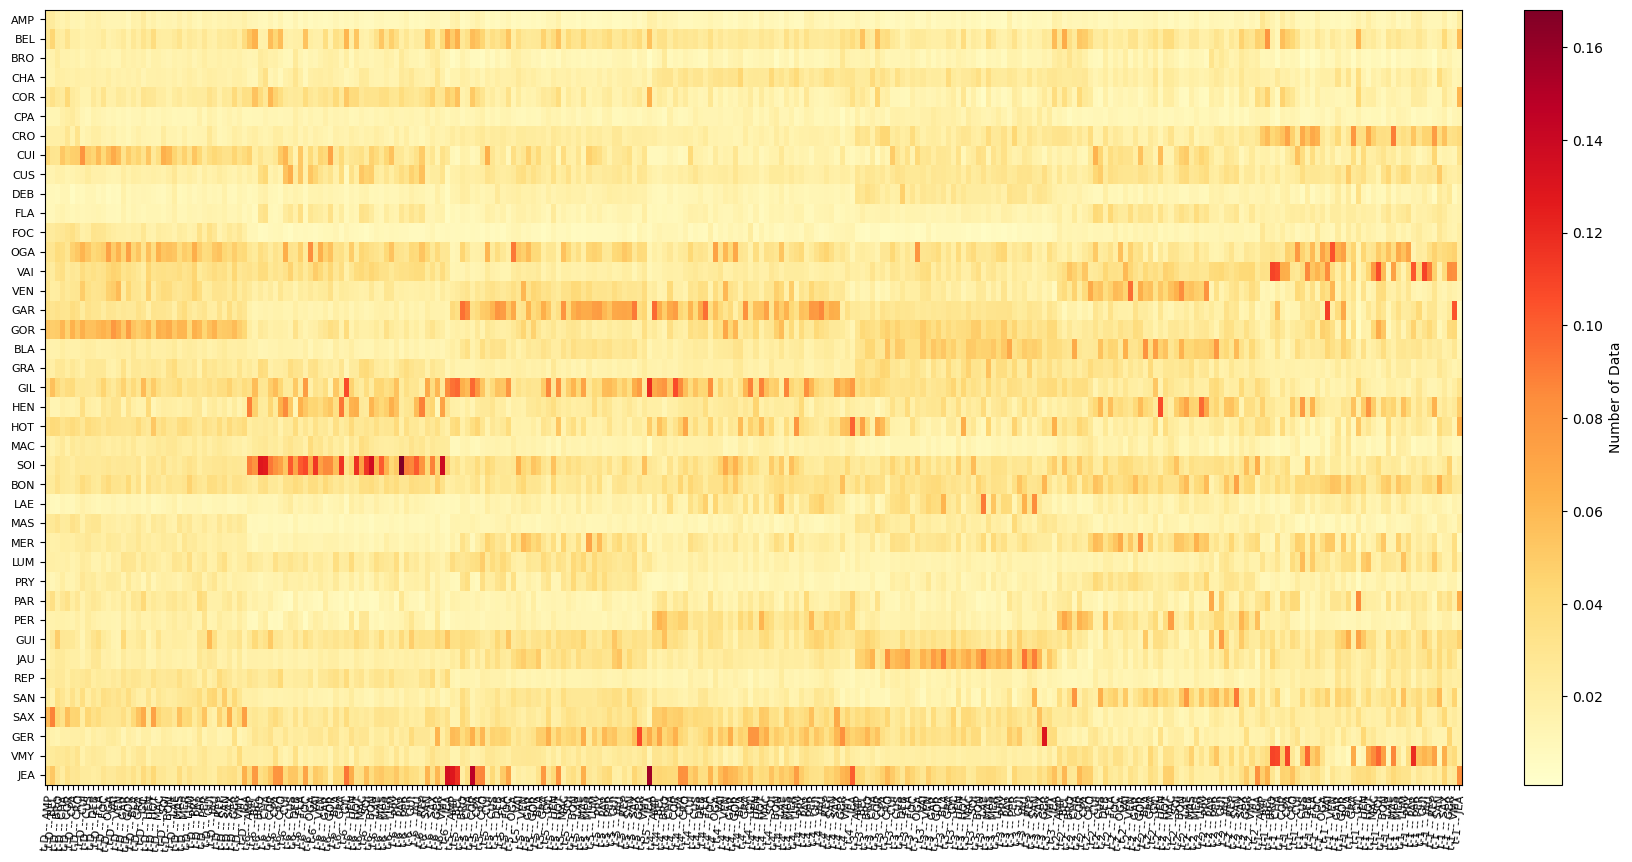

<Figure size 2000x1000 with 0 Axes>

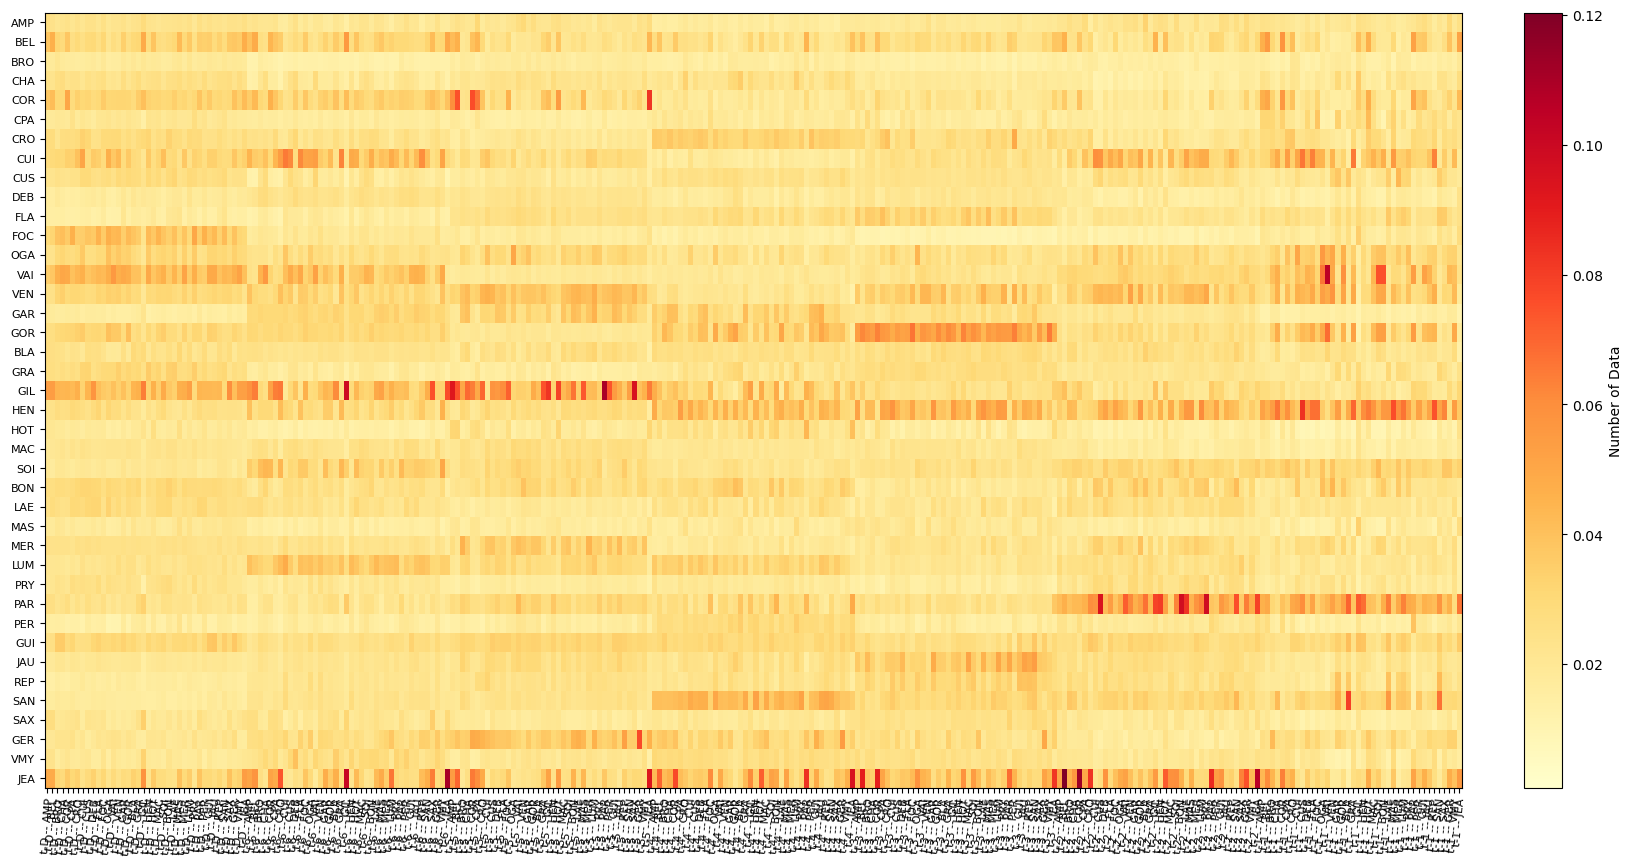

<Figure size 2000x1000 with 0 Axes>

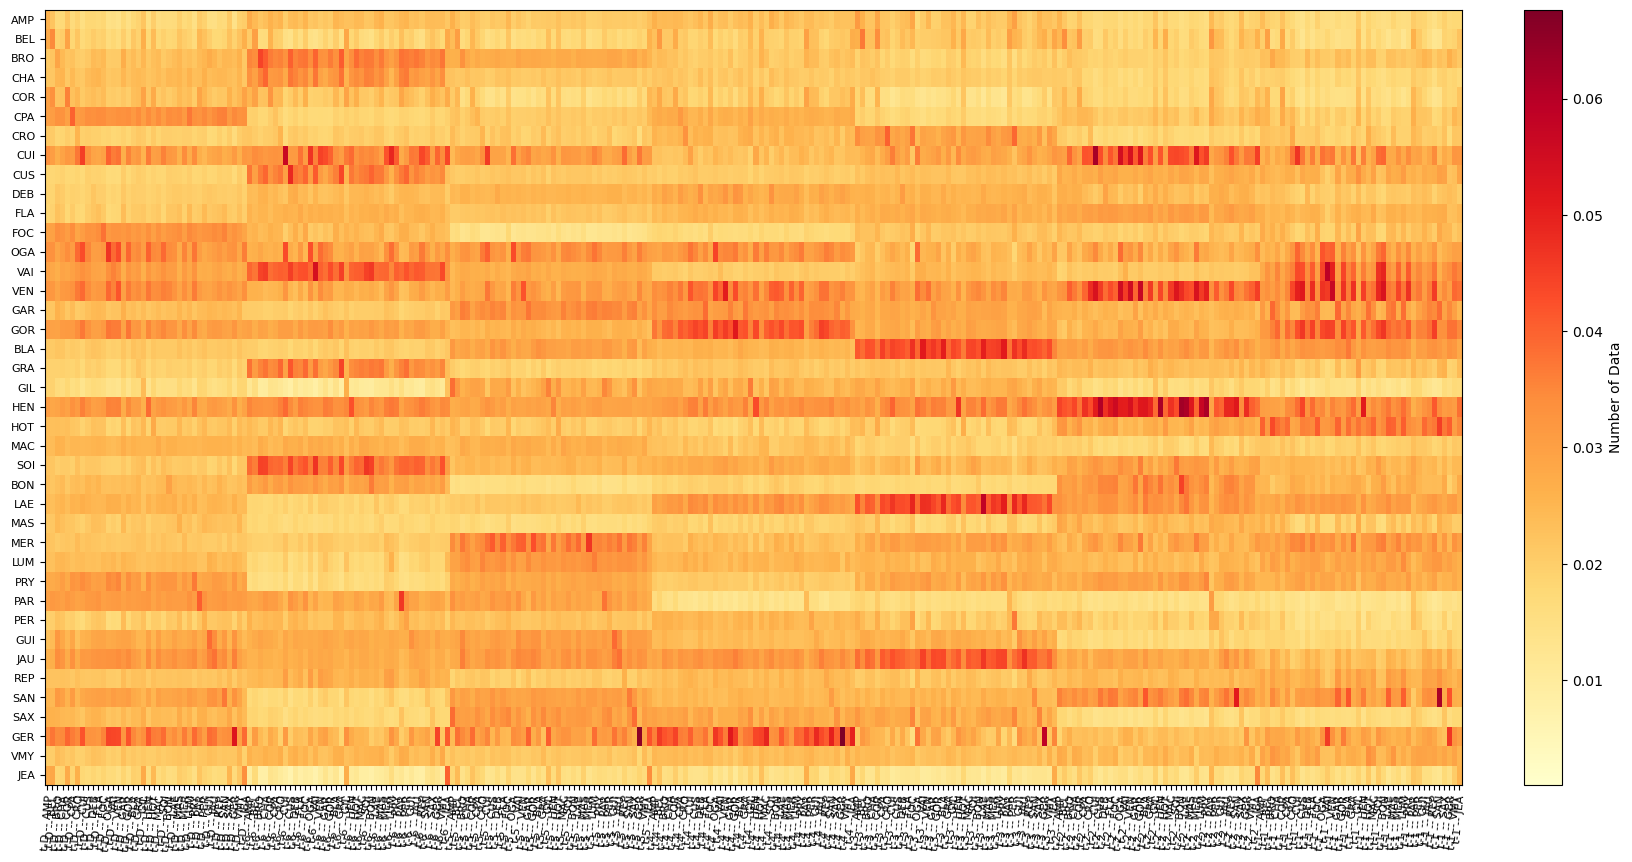

In [12]:

t_columns = ['t-D','t-6','t-5','t-4','t-3','t-2','t-1']

for temporal_layer in range(len(trainer.model._orig_mod.core_model.attn_layers_s)):
  attn_score = trainer.model._orig_mod.core_model.attn_layers_s[temporal_layer].attn.attn_score.detach().cpu()
  mean_attn_score = attn_score.mean(0)
  df_attn_weight = pd.DataFrame(mean_attn_score.reshape(-1,mean_attn_score.shape[-1]).numpy(),columns=ds.spatial_unit,index=[f"{hist} -- {station_name}"   for hist in t_columns  for station_name in ds.spatial_unit] )
  figsize=(20,10)
  matfig = plt.figure(figsize=figsize)
  plot_coverage_matshow(df_attn_weight.T, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False,
                          #   ,v_min=None,v_max=None,
                          #   display_values = False,
                            bool_plot = True,
                            cbar_magic_args = True,
                            figsize = figsize
  )

## STAEformer prediction Bike-out. Spatial Attn :

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 8760 elts between 2019-01-01 00:00:00 and 2019-12-31 23:00:00
Invalid dates within this fold: 211

>>>Tackle Target dataset: bike_out
Loading from /home/rrochas/../../data/rrochas/prediction_validation/agg_data/velov/velov_emitted_by_station1H.csv...


/home/rrochas/prediction-validation/pipeline/build_inputs/load_datasets_to_predict.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  coverage_i = pd.date_range(start=data_module.START, end=data_module.END, freq=args.freq)[:-1]
/home/rrochas/prediction-validation/pipeline/utils/utilities.py:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  INVALID_DATES = INVALID_DATES + list(pd.date_range(start,end,freq = freq))


df pivoted:  (17541, 434)
df reindexed :  (8760, 434)
Len coverage period:  8760
df filtered:  (8760, 434)
   Loaded data: (8760, 434)
   Dimension after spatial agg: (8760, 30)


/home/rrochas/prediction-validation/load_inputs/Lyon/bike/bike_in.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_pivoted = df_pivoted.reindex(pd.date_range(start =START, end = END, freq=target_freq)[:-1]).fillna(0)


   Init Dataset: 'torch.Size([8760, 30]). 0 Nan values
   TRAIN contextual_ds: torch.Size([5066, 30, 7])
   VALID contextual_ds: torch.Size([1689, 30, 7])
   TEST contextual_ds: torch.Size([1688, 30, 7])

>>>Loading calendar inputs ...

>>>Tackle Contextual dataset:  subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv


/home/rrochas/prediction-validation/load_inputs/Lyon/pt/subway_in.py:140: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample(args.freq).sum()




Restraining all datasets to train common dates: 5066 dates
Restraining all datasets to valid common dates: 1689 dates
Restraining all datasets to test common dates: 1688 dates

Size of Contextual datasets:
   Init Dataset: '[torch.Size([8760, 40])]
   TRAIN contextual_ds: [torch.Size([5066, 40, 7])]
   VALID contextual_ds: [torch.Size([1689, 40, 7])]
   TEST contextual_ds: [torch.Size([1688, 40, 7])]
Init U/Utarget size: torch.Size([8444, 30, 7])/torch.Size([8444, 30, 1]) Train/Valid/Test 5066 1689 1688

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

----------------------------------------
Loading the dataset for fold n°5
Model size: 0.004GB


<Figure size 2000x1000 with 0 Axes>

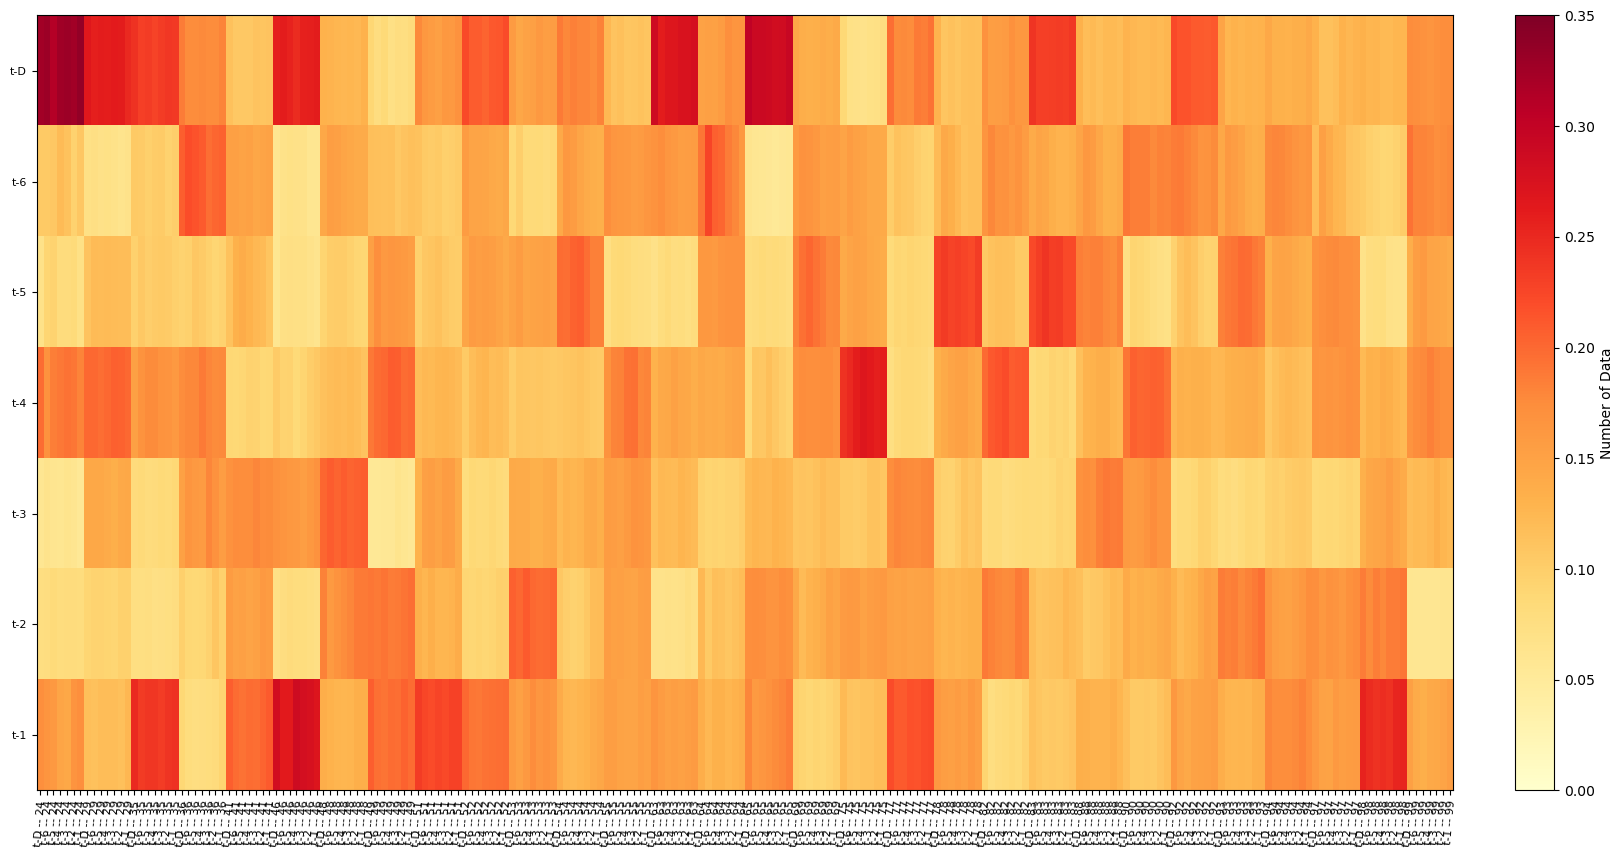

<Figure size 2000x1000 with 0 Axes>

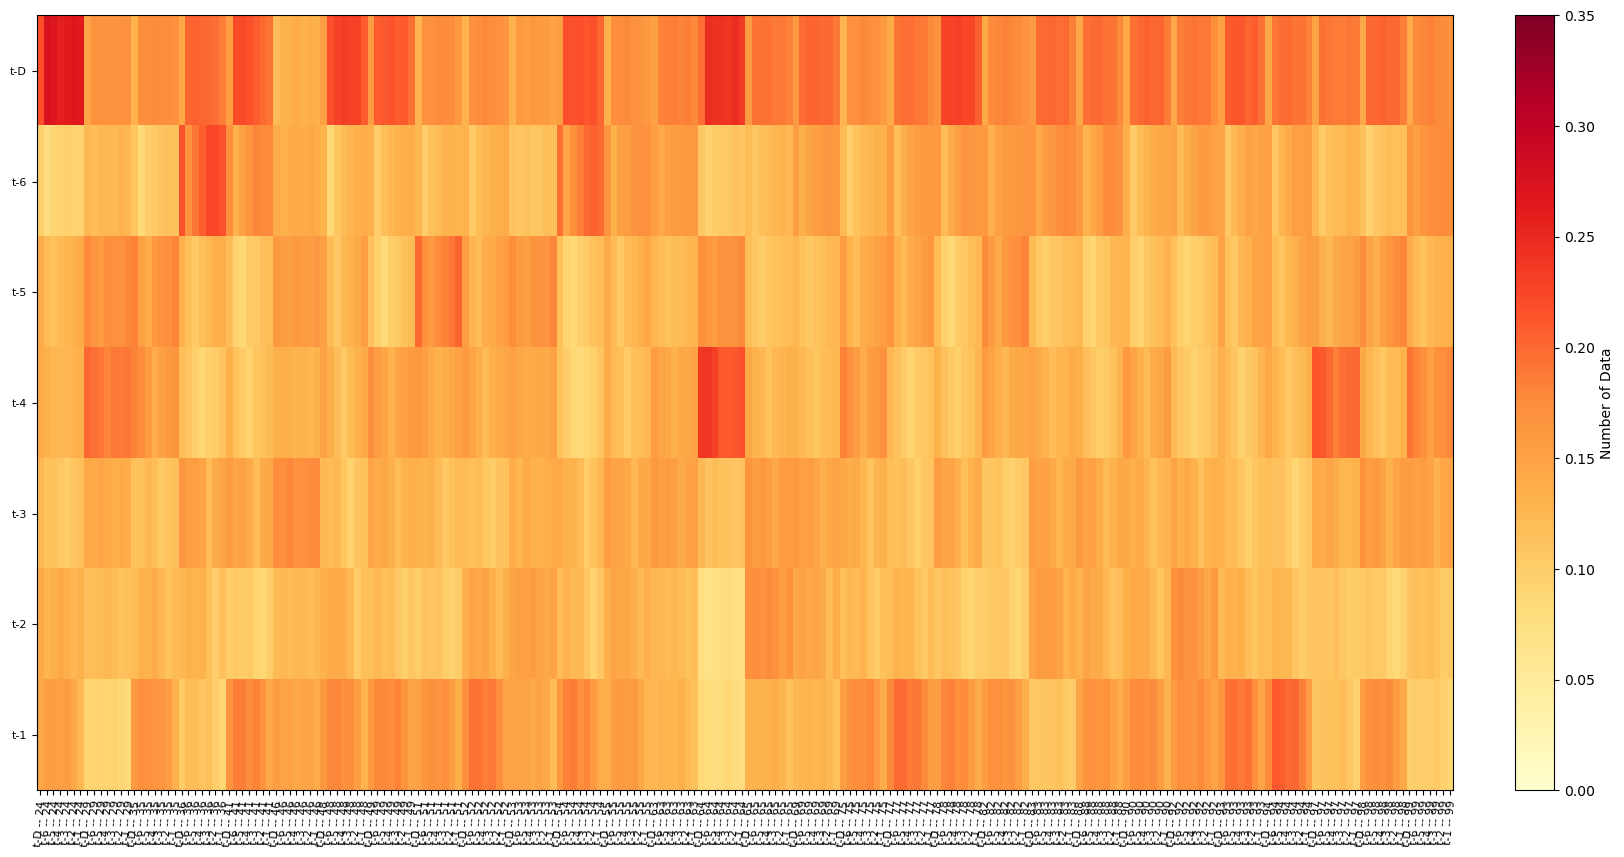

<Figure size 2000x1000 with 0 Axes>

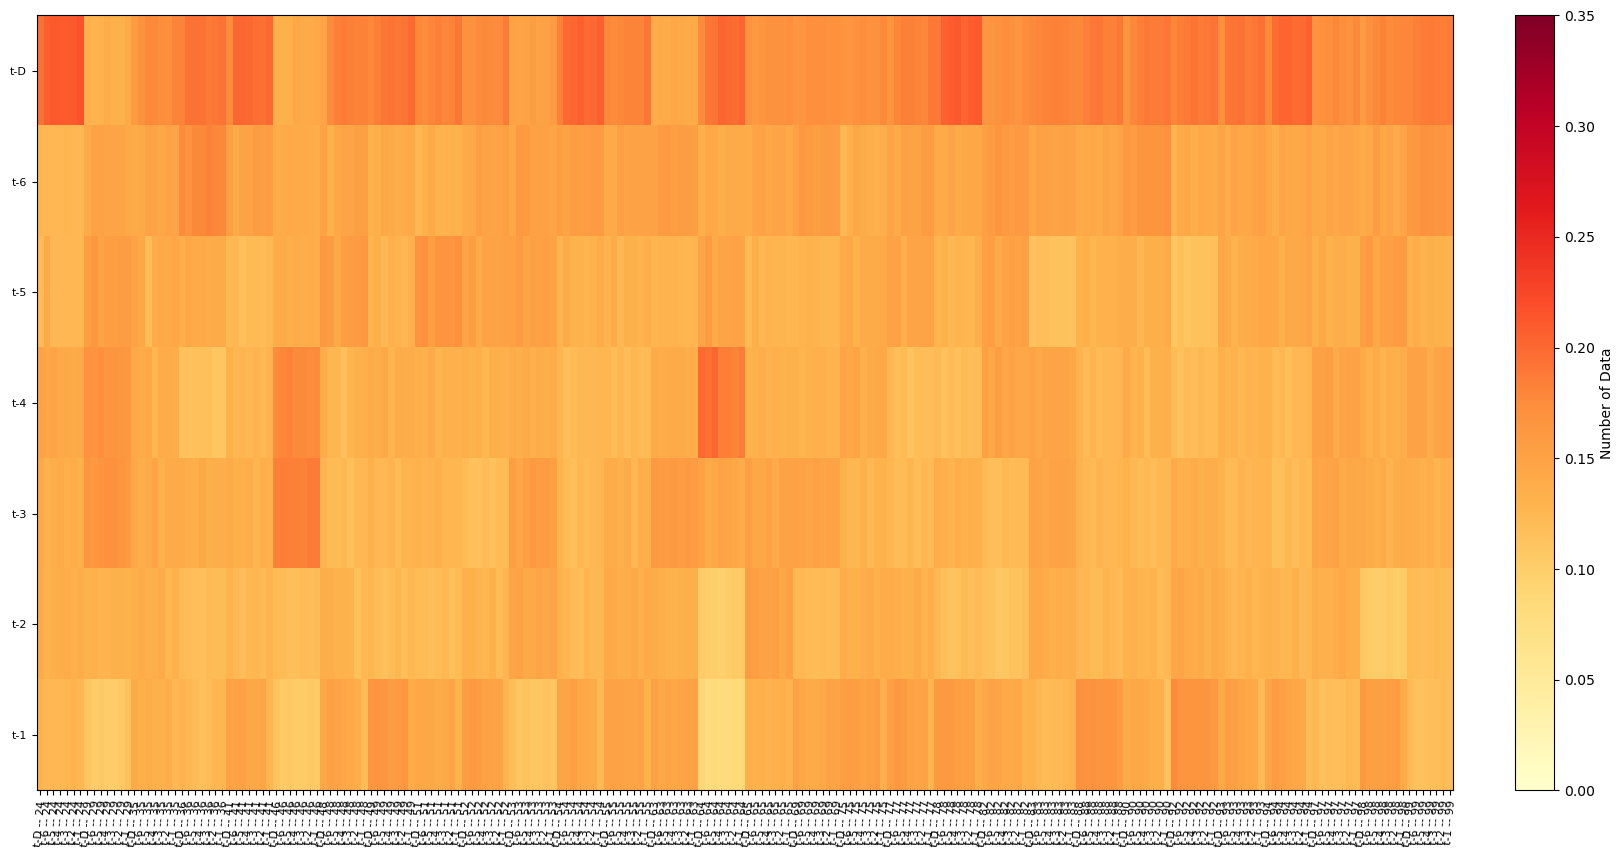

In [53]:
subfolder = 'best_models'
target_data = 'bike_out'
model_name = 'STAEformer'
trial_id = 'bike_out_subway_out_calendar_AttnKeepTempDimH4L3D128FF256_Agg100_Freq1H_e100_h1_bis1'  
trial_id = 'bike_out_subway_in_calendar_AttnKeepTempDimH4L3D128FF256_Agg100_Freq1H_e100_h1_bis1'
model_id = f"{trial_id}_f5"     # One trial_id can be associated to several folds 


model_args = pickle.load(open(f"{working_dir}/{target_data}_{model_name}/{subfolder}/model_args.pkl",'rb'))
model_save_path = f"{working_dir}/{target_data}_{model_name}/{subfolder}/{model_id}.pkl"

args_bike_out = model_args['model'][model_id]['args']
args_bike_out = Namespace(**args_bike_out)

trainer_bike_out, ds_bike_out, args_init_bike_out = load_trainer_ds_from_saved_trial(args_bike_out,model_save_path,
                                                          modification = {'shuffle':False,
                                                                           'data_augmentation':False ,
                                                                           'torch_compile':False})

## --- Plot time-series prediction and get inputs 
if False: 
  training_mode = 'test'
  station = [ds_bike_out.spatial_unit[0]]
  Preds,Y_true,T_labels = trainer_bike_out.testing(ds_bike_out.normalizer, training_mode =training_mode)   
  df_true,df_predictions = get_df_for_visualisation(ds_bike_out,Preds,Y_true,training_mode,trainer_bike_out.out_dim_factor,stations=station)
  visualisation_special_event(trainer_bike_out,df_true,df_predictions,station=station,min_flow=0)

  print('MAE: ',torch.abs(Y_true-Preds).mean().item(),'\n',
        'RMSE: ', np.sqrt(((Y_true-Preds)**2).mean().item()),'\n',
        'MSE: ', ((Y_true-Preds)**2).mean().item(),'\n'
  )

X = torch.cat([x for x,y,x_c  in trainer_bike_out.dataloader['test']]).to(args_init_bike_out.device)
Y = torch.cat([y for x,y,x_c  in trainer_bike_out.dataloader['test']]).to(args_init_bike_out.device)
Xc0 = torch.cat([x_c[0] for x,y,x_c  in trainer_bike_out.dataloader['test']]).to(args_init_bike_out.device)
Xc1 = torch.cat([x_c[1] for x,y,x_c  in trainer_bike_out.dataloader['test']]).to(args_init_bike_out.device)
Xc2 = torch.cat([x_c[2] for x,y,x_c  in trainer_bike_out.dataloader['test']]).to(args_init_bike_out.device)
model = trainer_bike_out.model
model.eval()
with torch.no_grad():
    pred = model(X,[Xc0,Xc1,Xc2])
# ---

## --- Analyse Attention Weights on Temporal dim :
columns = ['t-D','t-6','t-5','t-4','t-3','t-2','t-1']
for temporal_layer in range(len(trainer_bike_out.model.core_model.attn_layers_t)):
  attn_score_bike_out = trainer_bike_out.model.core_model.attn_layers_t[temporal_layer].attn.attn_score.detach().cpu()
  mean_attn_score_bike_out = attn_score_bike_out.mean(0)
  df_attn_weight_bike_out = pd.DataFrame(mean_attn_score_bike_out.reshape(-1,mean_attn_score_bike_out.shape[-1]).numpy(),columns=columns,index=[f"{hist} -- {station_name}"   for station_name in ds_bike_out.spatial_unit for hist in columns] )
  figsize=(20,10)
  matfig = plt.figure(figsize=figsize)
  plot_coverage_matshow(df_attn_weight_bike_out.T, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False,
                          #   ,v_min=None,v_max=None,
                          #   display_values = False,
                            bool_plot = True,
                            cbar_magic_args = True,
                            figsize = figsize,
                            v_min = 0,
                            v_max = 0.35
  )
# ---


<Figure size 2000x1000 with 0 Axes>

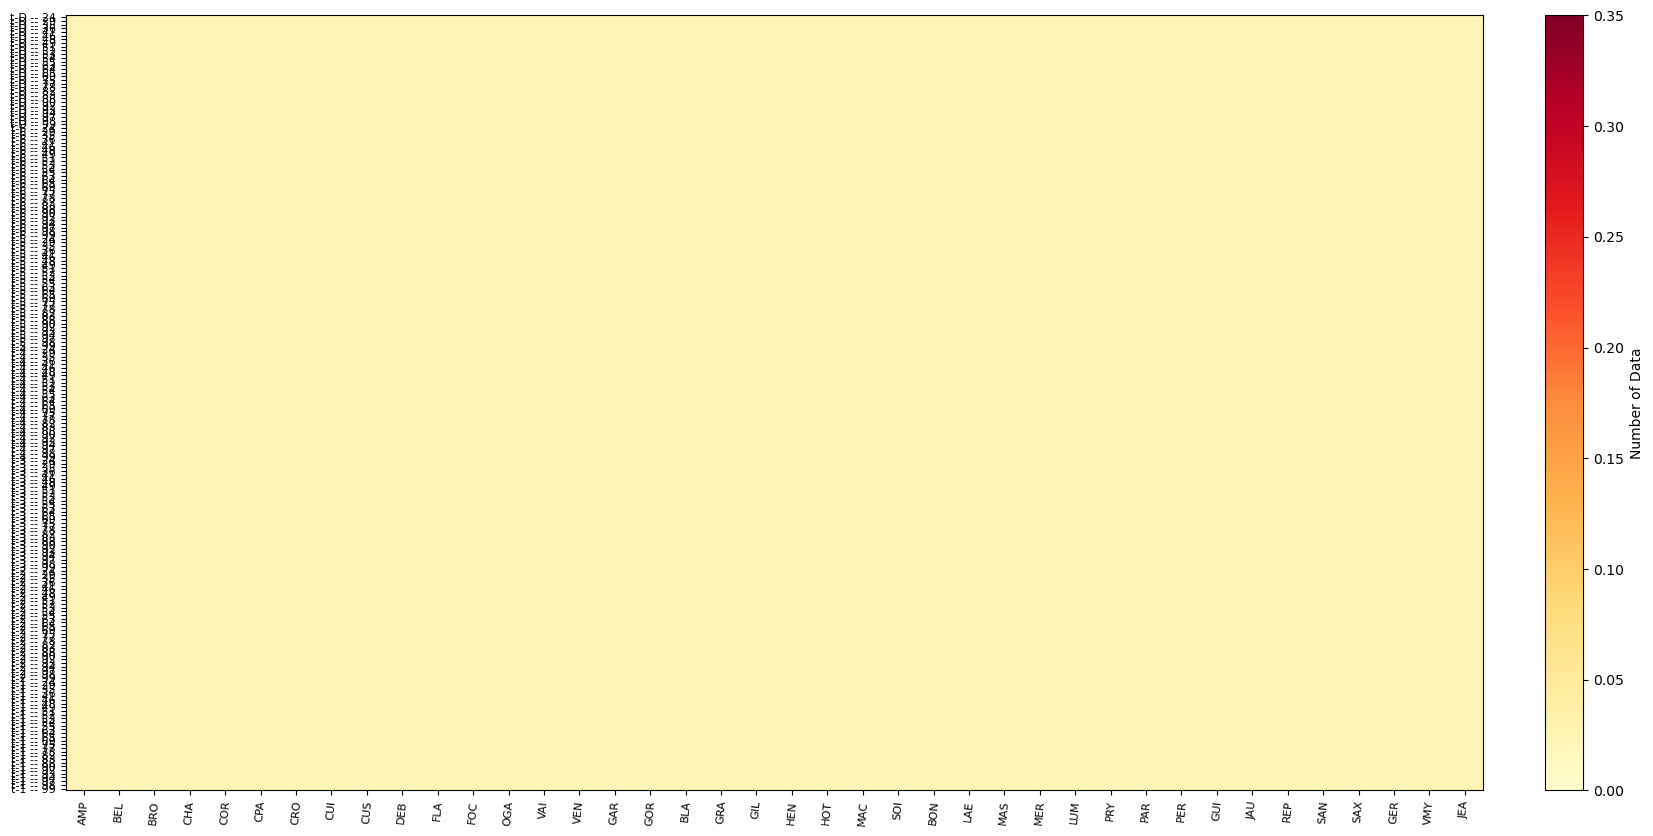

<Figure size 2000x1000 with 0 Axes>

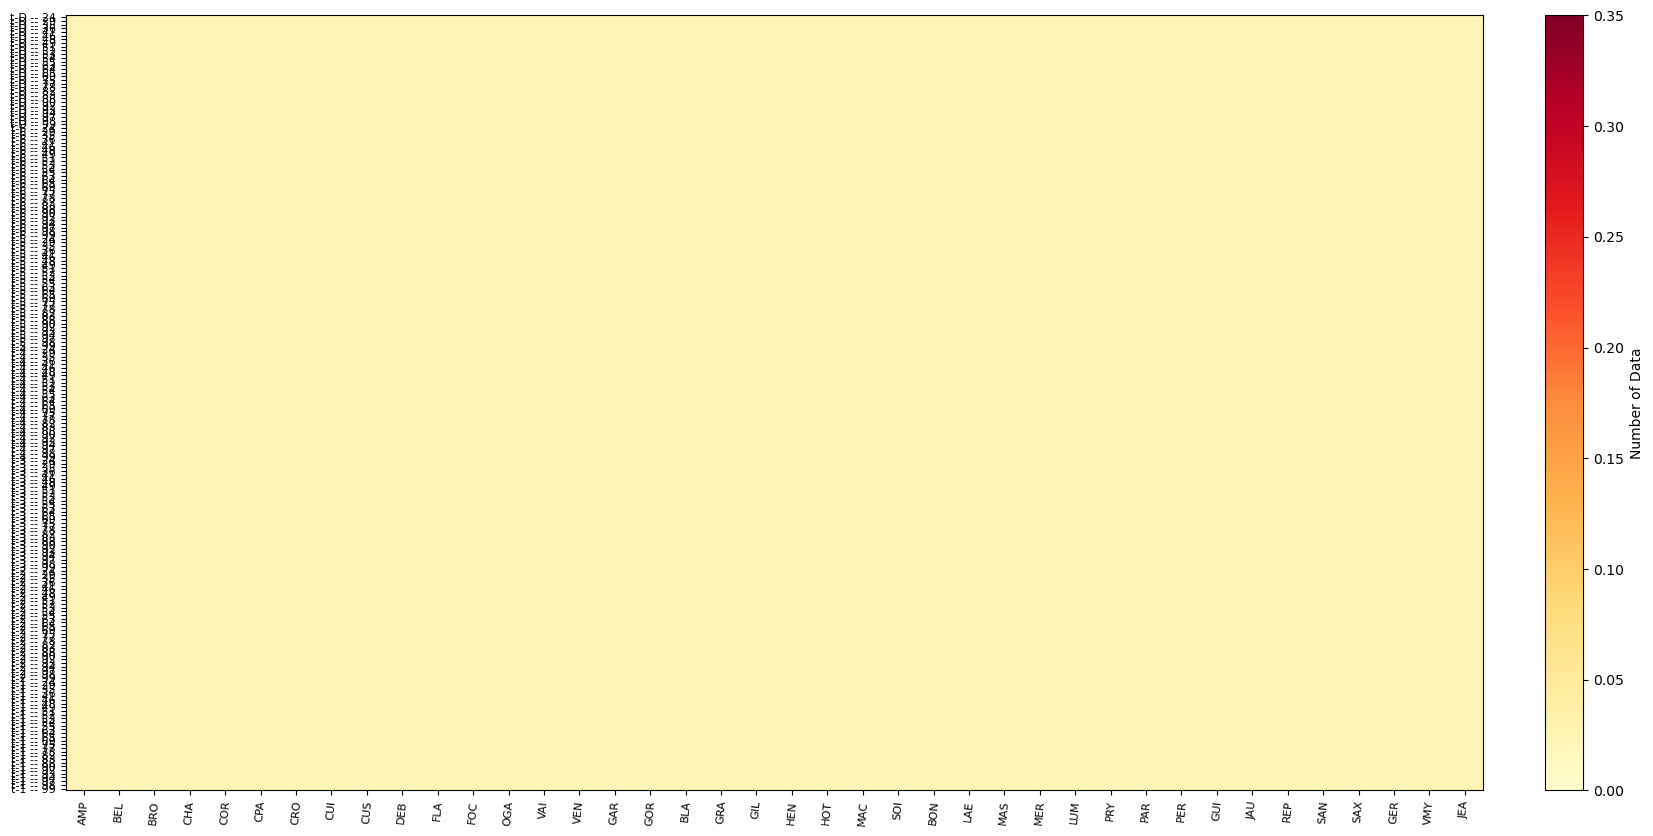

<Figure size 2000x1000 with 0 Axes>

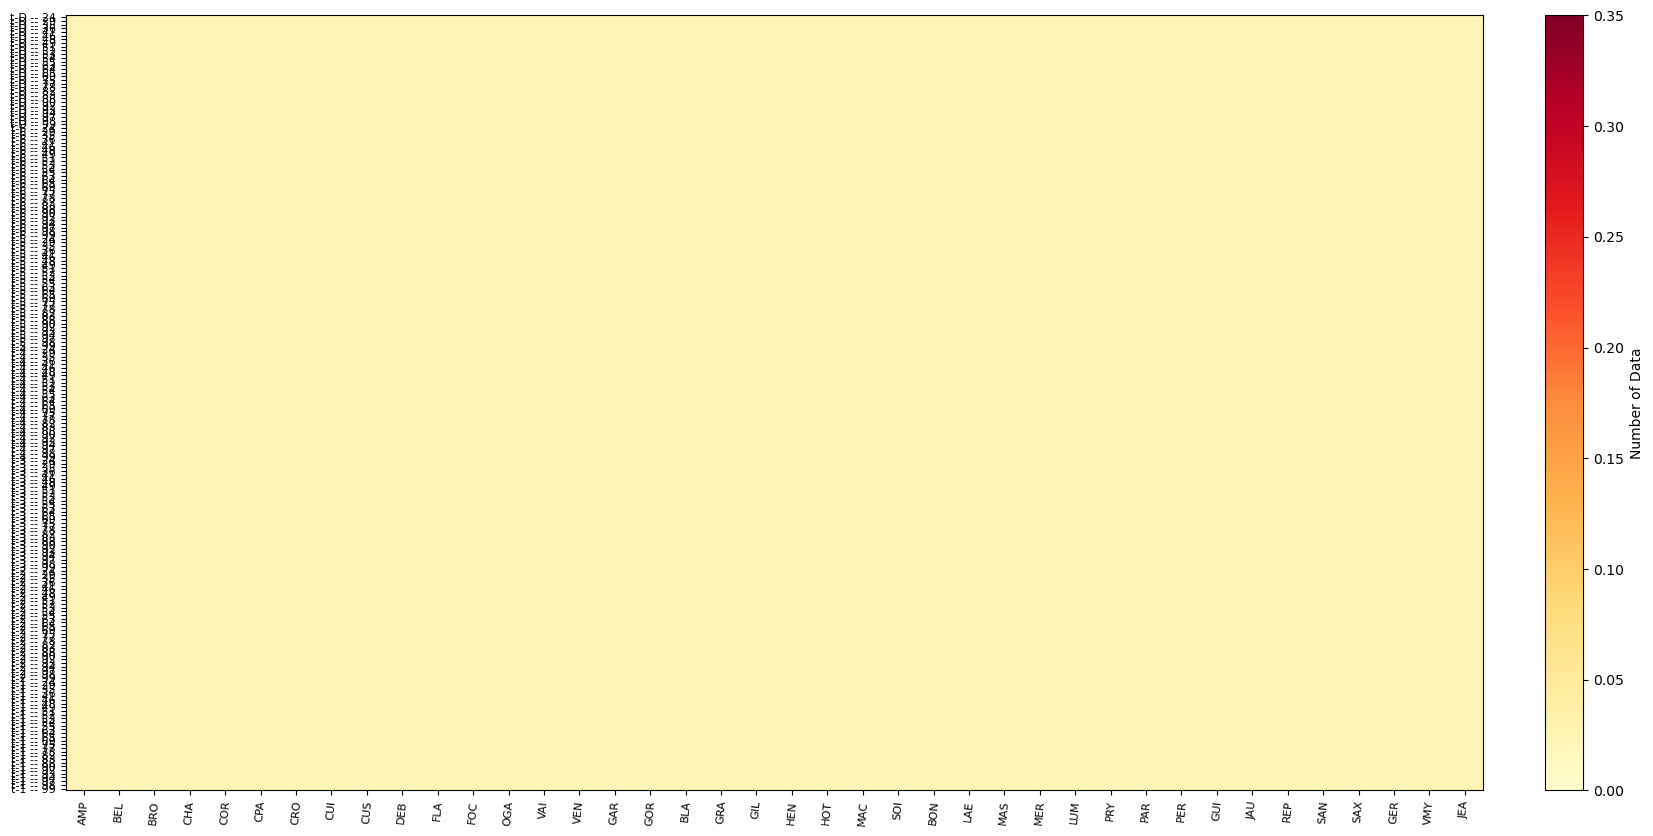

In [68]:
## --- Analyse Attention Weights on Temporal dim :
columns = ['t-D','t-6','t-5','t-4','t-3','t-2','t-1']
for mha_layer in range(len(trainer_bike_out.model.global_s_attn.subway_in.mha_list)):
  attn_score = trainer_bike_out.model.global_s_attn.subway_in.mha_list[mha_layer].attn_weight.detach().cpu()  # []
  attn_score = attn_score.view(-1,attn_score.size(2),attn_score.size(3),attn_score.size(4))   # [B*H,L,P,N]
  mean_attn_score = attn_score.mean(0)  #  [L,P,N]
  mean_attn_score = mean_attn_score.permute(2,1,0)    #  [N,P,L]
  df_attn_weight = pd.DataFrame(mean_attn_score.reshape(mean_attn_score.shape[0],-1).numpy(),
                                index = ds.spatial_unit,
                                columns =[f"{hist} -- {bike_station}"   for hist in columns for bike_station in ds_bike_out.spatial_unit] )
  figsize=(20,10)
  matfig = plt.figure(figsize=figsize)
  plot_coverage_matshow(df_attn_weight.T, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False,
                          #   ,v_min=None,v_max=None,
                          #   display_values = False,
                            bool_plot = True,
                            cbar_magic_args = True,
                            figsize = figsize,
                            v_min = 0,
                            v_max = 0.35
  )
# ---

In [67]:
mean_attn_score.size()

torch.Size([7, 30, 40])

In [ ]:
.size()

torch.Size([6752, 7, 30, 40])